# Data Preprocessing and EDA

##    Libraries Import

In [73]:
import os

import warnings

import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory


def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper

import warnings
warnings.filterwarnings('ignore')

__refresh__ = 0


def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print(
                "Using Cache, Set Refresh to '__refresh__=1' to regenerate "
                "the output of this  function"
            )

    return wrapper

def gen_train_test(X,y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, stratify=y, random_state=10)
    return X_train, X_test, y_train, y_test

###    ColumnSelectors

In [30]:
class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio

    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data


column_directory = ColumnSelectors()

###    Customised Polywrappers

In [31]:
import copy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
import category_encoders as encoders
import pandas as pd
import numpy as np
from abc import abstractmethod
from enum import Enum, auto

import sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import NotFittedError
from typing import Dict, List, Optional, Union
from scipy.sparse import csr_matrix


def utils_convert_inputs(X, y, columns=None, index=None, deep=False):
    """
    Unite arraylike `X` and vectorlike `y` into a DataFrame and Series.
    If both are pandas types already, raises an error if their indexes do not match.
    If one is pandas, the returns will share that index.
    If neither is pandas, a default index will be used, unless `index` is passed.
    Parameters
    ----------
    X: arraylike
    y: listlike
    columns: listlike
        Specifies column names to use for `X`.
        Ignored if `X` is already a dataframe.
        If `None`, use the default pandas column names.
    index: listlike
        The index to use, if neither `X` nor `y` is a pandas type.
        (If one has an index, then this has no effect.)
        If `None`, use the default pandas index.
    deep: bool
        Whether to deep-copy `X`.
    """
    X_alt_index = y.index if isinstance(y, pd.Series) else index
    X = utils_convert_input(X, columns=columns, deep=deep, index=X_alt_index)
    if y is not None:
        y = utils_convert_input_vector(y, index=X.index)
        # N.B.: If either was already pandas, it keeps its index.

        if any(X.index != y.index):
            raise ValueError("`X` and `y` both have indexes, but they do not match.")
        if X.shape[0] != y.shape[0]:
            raise ValueError(
                "The length of X is "
                + str(X.shape[0])
                + " but length of y is "
                + str(y.shape[0])
                + "."
            )
    return X, y


def utils_convert_input(X, columns=None, deep=False, index=None):
    """
    Unite data into a DataFrame.
    Objects that do not contain column names take the names from the argument.
    Optionally perform deep copy of the data.
    """
    if not isinstance(X, pd.DataFrame):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X, copy=deep)
        else:
            if columns is not None and np.size(X, 1) != len(columns):
                raise ValueError(
                    "The count of the column names does not correspond to the count of the columns"
                )
            if isinstance(X, list):
                X = pd.DataFrame(
                    X, columns=columns, copy=deep, index=index
                )  # lists are always copied, but for consistency, we still pass the argument
            elif isinstance(X, (np.generic, np.ndarray)):
                X = pd.DataFrame(X, columns=columns, copy=deep, index=index)
            elif isinstance(X, csr_matrix):
                X = pd.DataFrame(X.todense(), columns=columns, copy=deep, index=index)
            else:
                raise ValueError(f"Unexpected input type: {type(X)}")
    elif deep:
        X = X.copy(deep=True)

    return X


def utils_convert_input_vector(y, index):
    """
    Unite target data type into a Series.
    If the target is a Series or a DataFrame, we preserve its index.
    But if the target does not contain index attribute, we use the index from the argument.
    """
    if y is None:
        raise ValueError(
            "Supervised encoders need a target for the fitting. The target cannot be None"
        )
    if isinstance(y, pd.Series):
        return y
    elif isinstance(y, np.ndarray):
        if len(np.shape(y)) == 1:  # vector
            return pd.Series(y, name="target", index=index)
        elif len(np.shape(y)) == 2 and np.shape(y)[0] == 1:  # single row in a matrix
            return pd.Series(y[0, :], name="target", index=index)
        elif len(np.shape(y)) == 2 and np.shape(y)[1] == 1:  # single column in a matrix
            return pd.Series(y[:, 0], name="target", index=index)
        else:
            raise ValueError(f"Unexpected input shape: {np.shape(y)}")
    elif np.isscalar(y):
        return pd.Series([y], name="target", index=index)
    elif isinstance(y, list):
        if len(y) == 0:  # empty list
            return pd.Series(y, name="target", index=index, dtype=float)
        elif len(y) > 0 and not isinstance(y[0], list):  # vector
            return pd.Series(y, name="target", index=index)
        elif (
            len(y) > 0 and isinstance(y[0], list) and len(y[0]) == 1
        ):  # single row in a matrix
            flatten = lambda y: [item for sublist in y for item in sublist]
            return pd.Series(flatten(y), name="target", index=index)
        elif (
            len(y) == 1 and len(y[0]) == 0 and isinstance(y[0], list)
        ):  # single empty column in a matrix
            return pd.Series(y[0], name="target", index=index, dtype=float)
        elif len(y) == 1 and isinstance(y[0], list):  # single column in a matrix
            return pd.Series(y[0], name="target", index=index, dtype=type(y[0][0]))
        else:
            raise ValueError("Unexpected input shape")
    elif isinstance(y, pd.DataFrame):
        if len(list(y)) == 0:  # empty DataFrame
            return pd.Series(name="target", index=index, dtype=float)
        if len(list(y)) == 1:  # a single column
            return y.iloc[:, 0]
        else:
            raise ValueError(f"Unexpected input shape: {y.shape}")
    else:
        return pd.Series(
            y, name="target", index=index
        )  # this covers tuples and other directly convertible types

class PolynomialWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, feature_encoder):
        self.feature_encoder = feature_encoder
        self.feature_encoders = {}
        self.label_encoder = None

    def fit(self, X, y, **kwargs):
        # unite the input into pandas types
        X, y = utils_convert_inputs(X, y)
        y = pd.DataFrame(y, columns=["target"])

        # apply one-hot-encoder on the label
        self.label_encoder = encoders.OneHotEncoder(
            handle_missing="error",
            handle_unknown="error",
            cols=["target"],
            drop_invariant=False,
            use_cat_names=True,
        )
        labels = self.label_encoder.fit_transform(y)
        labels.columns = [column[7:] for column in labels.columns]
        # labels = labels.iloc[:, 1:]  # drop one label

        # train the feature encoders
        for class_name, label in labels.iteritems():
            self.feature_encoders[class_name] = copy.deepcopy(self.feature_encoder).fit(
                X, label
            )

    def transform(self, X):
        # unite the input into pandas types
        X = utils_convert_input(X)

        # initialization
        encoded = None
        feature_encoder = None
        all_new_features = pd.DataFrame()

        # transform the features
        for class_name, feature_encoder in self.feature_encoders.items():
            encoded = feature_encoder.transform(X)

            # decorate the encoded features with the label class suffix
            new_features = encoded[feature_encoder.cols]
            new_features.columns = [
                str(column) + "_" + class_name for column in new_features.columns
            ]

            all_new_features = pd.concat((all_new_features, new_features), axis=1)

        # add features that were not encoded
        result = pd.concat(
            (
                encoded[encoded.columns[~encoded.columns.isin(feature_encoder.cols)]],
                all_new_features,
            ),
            axis=1,
        )

        return result

    def fit_transform(self, X, y=None, **fit_params):
        # When we are training the feature encoders, we have to use fit_transform() method on the features.

        # unite the input into pandas types
        X, y = utils_convert_inputs(X, y)
        y = pd.DataFrame(y, columns=["target"])

        # apply one-hot-encoder on the label
        self.label_encoder = encoders.OneHotEncoder(
            handle_missing="error",
            handle_unknown="error",
            cols=["target"],
            drop_invariant=True,
            use_cat_names=True,
        )
        labels = self.label_encoder.fit_transform(y)
        labels.columns = [column[7:] for column in labels.columns]
        # labels = labels.iloc[:, 1:]  # drop one label

        # initialization of the feature encoders
        encoded = None
        feature_encoder = None
        all_new_features = pd.DataFrame()

        # fit_transform the feature encoders
        for class_name, label in labels.iteritems():
            feature_encoder = copy.deepcopy(self.feature_encoder)
            encoded = feature_encoder.fit_transform(X, label)

            # decorate the encoded features with the label class suffix
            new_features = encoded[feature_encoder.cols]
            new_features.columns = [
                str(column) + "_" + class_name for column in new_features.columns
            ]

            all_new_features = pd.concat((all_new_features, new_features), axis=1)
            self.feature_encoders[class_name] = feature_encoder

        # add features that were not encoded
        result = pd.concat(
            (
                encoded[encoded.columns[~encoded.columns.isin(feature_encoder.cols)]],
                all_new_features,
            ),
            axis=1,
        )

        return result

In [32]:
"""
TEST
"""
"""
# from sklearn.datasets import *
tmp = raw_data.loc[:, nominal].astype("category")
target = raw_data.target
encoder = PolynomialWrapper(TargetEncoder())
tmp_t = encoder.fit_transform(tmp, target)
"""

'\n# from sklearn.datasets import *\ntmp = raw_data.loc[:, nominal].astype("category")\ntarget = raw_data.target\nencoder = PolynomialWrapper(TargetEncoder())\ntmp_t = encoder.fit_transform(tmp, target)\n'

## Prepare Data and Execution Enviroment

### Rename Columns and Start Data Save

In [33]:
DATA_PATH = "/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH = "/kaggle/working/"
TRAIN_DATA = "train.csv"
TEST_DATA = "test.csv"
KAGGLE_ENV = 1

cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = "../data"
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH = LOCAL_PATH + DATA_SAVE_PATH


def write_raw_data(raw_data: pd.DataFrame, raw_data_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


# TODO rerun this script to rename the target column


def reload_raw_data():
    global DATA_SAVE_PATH
    raw_data = pd.read_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval


@run_if_refresh
def rename_columns_with_dtype(DATA_PATH=DATA_PATH, DATA_SAVE_PATH=DATA_SAVE_PATH):
    raw_data = pd.read_csv(DATA_PATH + TRAIN_DATA, index_col=0)
    raw_data_eval = pd.read_csv(DATA_PATH + TEST_DATA, index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split("__")
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    raw_data.rename(columns=raw_dtypes_info, inplace=True)
    raw_data_eval.rename(columns=raw_dtypes_info, inplace=True)
    raw_data.rename(columns={"label": "target"}, inplace=True)
    write_raw_data(raw_data, raw_data_eval)
    # raw_data.to_parquet(DATA_SAVE_PATH+'train.parquet')
    # raw_data_eval.to_parquet(DATA_SAVE_PATH+'test.parquet')


rename_columns_with_dtype()

Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


### Load Renamed Data

In [34]:
raw_data, raw_data_eval = reload_raw_data()

### Load Metadata

In [35]:
ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

### Delete Unwanted Categories

#### Unique Categories within each feature

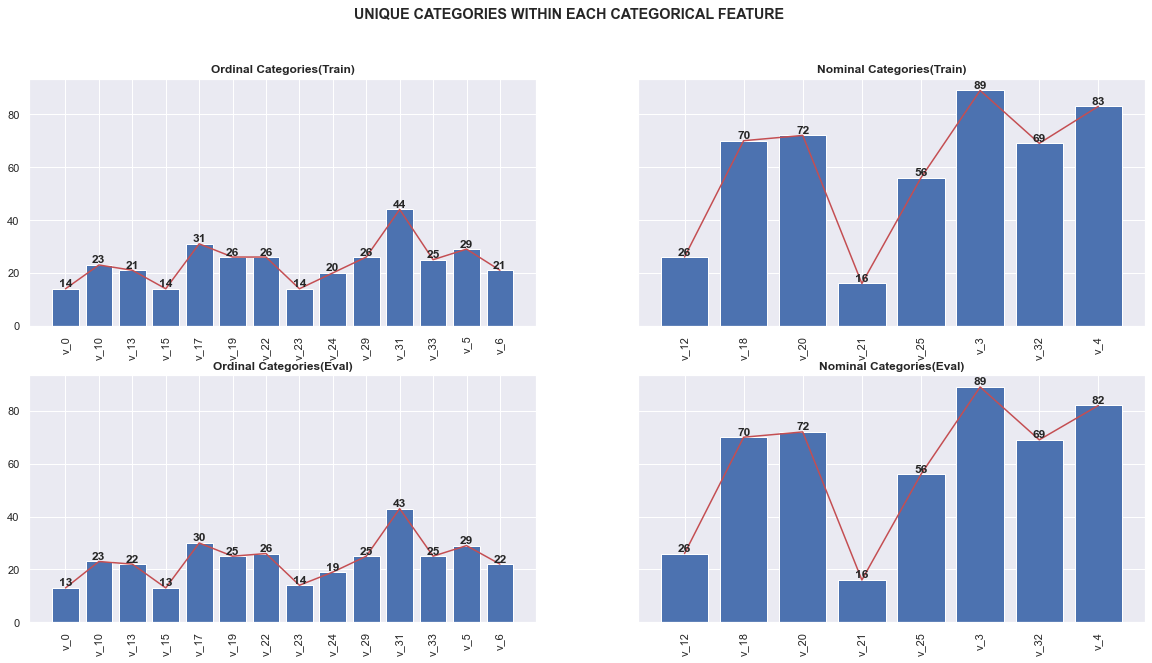

In [36]:
"""
Unique Categories within each categorical feature.
"""
fig, ax = plt.subplots(2, 2, figsize=(20, 10), squeeze=False, sharey=True)
data_to_plot = [ordinal_data, nominal_data, ordinal_data_eval, nominal_data_eval]
fig.suptitle(
    "Unique Categories within each categorical feature".upper(), fontweight="bold"
)
data_titles = [
    "Ordinal Categories(Train)",
    "Nominal Categories(Train)",
    "Ordinal Categories(Eval)",
    "Nominal Categories(Eval)",
]
idx = 0
for i in range(2):
    for j in range(2):
        ax_ = ax[i, j]
        data = data_to_plot[idx]

        values = data.nunique().values
        Xlabels = [x.split("__")[1] for x in data.nunique().index]
        disp = ax_.bar(x=Xlabels, height=values)
        disp1 = ax_.set_title(data_titles[idx], fontweight="bold")
        disp2 = ax_.set_xticklabels(Xlabels, rotation=90)
        ax_.bar_label(container=disp, fontweight="bold")
        ax_.plot(values, "-r")
        idx += 1

##### Nominal Categories to Delete

In [37]:
"""
Nominal Categories to delete = Unique_Categories (Union - Intersection)
"""


def find_nominal_uncommon_categories(
    nominal_data=nominal_data, nominal_data_eval=nominal_data_eval
):
    missing_categories_dict = {}
    for c in nominal:
        nominal_data[c]: pd.Series
        unique_categories_train = set(nominal_data[c].unique())
        # print(unique_categories_test)
        unique_categories_eval = set(nominal_data_eval[c].unique())
        all_categories = unique_categories_train.union(unique_categories_eval)
        common_categories = unique_categories_train.intersection(unique_categories_eval)
        missing_categories = all_categories - common_categories
        missing_categories_dict[c] = list(missing_categories)
    return missing_categories_dict


missing_categories_dict = find_nominal_uncommon_categories()


def classify_uncommon_nominal_categories_zero(row):
    for c in nominal:
        if row[c] in missing_categories_dict[c]:
            row[c] = 0
    return row


nominal_data_t = nominal_data.copy()
nominal_data_t = nominal_data_t.apply(classify_uncommon_nominal_categories_zero, axis=1)

nominal_data_eval_t = nominal_data_eval.copy()
nominal_data_eval_t = nominal_data_eval.apply(
    classify_uncommon_nominal_categories_zero, axis=1
)

In [38]:
total_ambiguos_labels_master = {k: 0 for k in nominal}
total_ambiguos_labels_train = {k: 0 for k in nominal}
total_ambiguos_labels_eval = {k: 0 for k in nominal}

for k, v in missing_categories_dict.items():
    value_counts_train = nominal_data[k].value_counts().to_dict()
    value_counts_eval = nominal_data_eval[k].value_counts().to_dict()
    # print(value_counts_train)
    for val in v:
        if val in value_counts_train:
            # if k in total_ambiguos_labels_train:
            total_ambiguos_labels_train[k] += value_counts_train[val]
            total_ambiguos_labels_master[k] += value_counts_train[val]
        if val in value_counts_eval:
            total_ambiguos_labels_eval[k] += value_counts_eval[val]
            total_ambiguos_labels_master[k] += value_counts_eval[val]

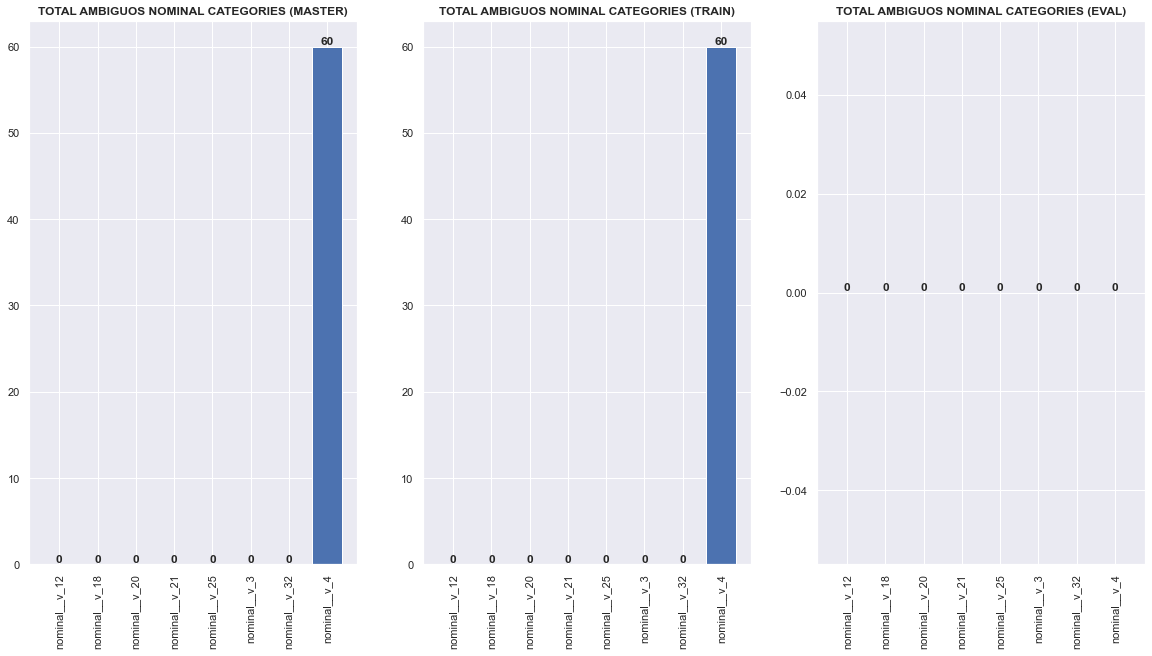

In [39]:
data_to_plot = [
    total_ambiguos_labels_master,
    total_ambiguos_labels_train,
    total_ambiguos_labels_eval,
]
data_titles = [
    "Total Ambiguos Nominal Categories (Master)",
    "Total Ambiguos Nominal Categories (Train)",
    "Total Ambiguos Nominal Categories (Eval)",
]
fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(20, 10))

for idx in range(3):
    # ax_ = ax[idx]
    data = data_to_plot[idx]
    disp = ax[0, idx].bar(data.keys(), height=data.values())
    disp1 = ax[0, idx].set_xticklabels(data.keys(), rotation=90)
    disp = ax[0, idx].bar_label(container=disp, fontweight="bold")
    disp2 = ax[0, idx].set_title(data_titles[idx].upper(), fontweight="bold")

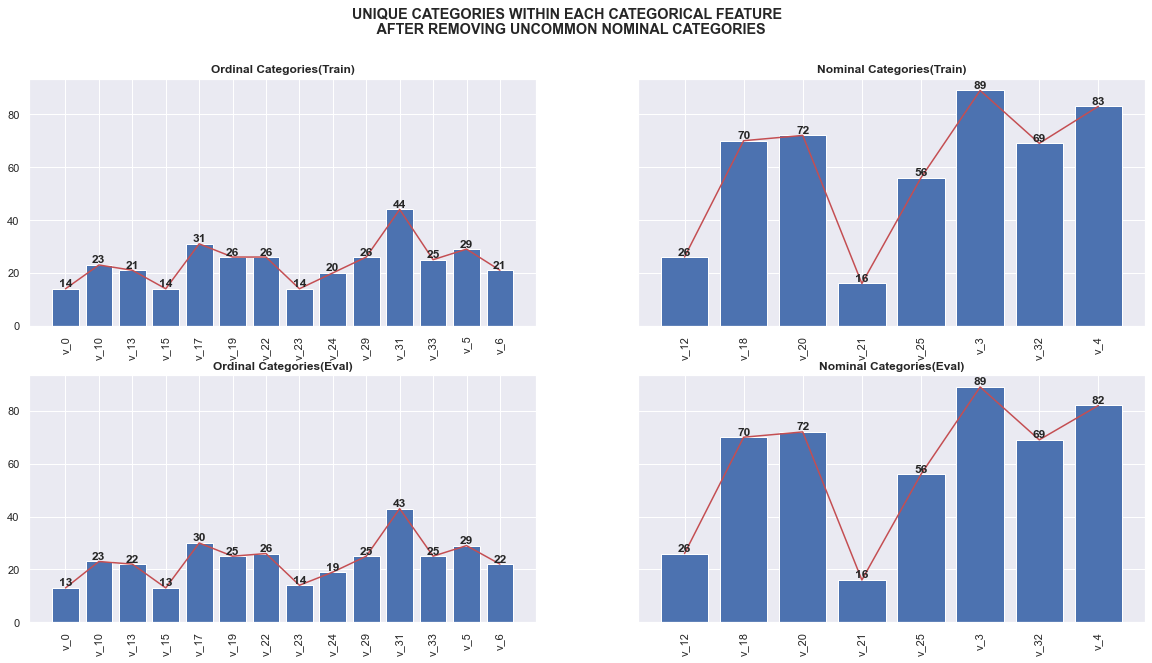

In [40]:
"""
Unique Categories within each categorical feature.
"""
fig, ax = plt.subplots(2, 2, figsize=(20, 10), squeeze=False, sharey=True)
data_to_plot = [ordinal_data, nominal_data_t, ordinal_data_eval, nominal_data_eval_t]
fig.suptitle(
    "Unique Categories within each categorical feature \n After removing uncommon nominal categories".upper(),
    fontweight="bold",
)
data_titles = [
    "Ordinal Categories(Train)",
    "Nominal Categories(Train)",
    "Ordinal Categories(Eval)",
    "Nominal Categories(Eval)",
]
idx = 0
for i in range(2):
    for j in range(2):
        ax_ = ax[i, j]
        data = data_to_plot[idx]

        values = data.nunique().values
        Xlabels = [x.split("__")[1] for x in data.nunique().index]
        disp = ax_.bar(x=Xlabels, height=values)
        disp1 = ax_.set_title(data_titles[idx], fontweight="bold")
        disp2 = ax_.set_xticklabels(Xlabels, rotation=90)
        ax_.bar_label(container=disp, fontweight="bold")
        ax_.plot(values, "-r")
        idx += 1

##### Ordinal Categories to delete

In [41]:
"""
Ordinal Categories to delete = Unique_Categories (Union - Intersection)
"""


def find_ordinal_uncommon_categories(
    ordinal_data=ordinal_data, ordinal_data_eval=ordinal_data_eval
):
    missing_categories_dict = {}
    for c in ordinal:
        nominal_data[c]: pd.Series
        unique_categories_train = set(ordinal_data[c].unique())
        # print(unique_categories_test)
        unique_categories_eval = set(ordinal_data_eval[c].unique())
        all_categories = unique_categories_train.union(unique_categories_eval)
        common_categories = unique_categories_train.intersection(unique_categories_eval)
        missing_categories = all_categories - common_categories
        missing_categories_dict[c] = list(missing_categories)
    return missing_categories_dict


missing_categories_dict = find_ordinal_uncommon_categories()
missing_categories_count_ordinal = {
    k: len(v) for k, v in missing_categories_dict.items()
}

# fig, ax = plt.subplots(1,1)
# disp = ax.bar(missing_categories_count_nominal.keys(), height=missing_categories_count_nominal.values())
# disp1 = ax.set_xticklabels(missing_categories_count_nominal.keys(), rotation=90)
# # ax[0].bar_label(container=disp,fontweight='bold')
# disp = ax.bar_label(container=disp,fontweight='bold')
def classify_uncommon_ordinal_categories_zero(row):
    for c in ordinal:
        if row[c] in missing_categories_dict[c]:
            row[c] = 0
    return row


ordinal_data_t = ordinal_data.copy()
ordinal_data_t = ordinal_data_t.apply(classify_uncommon_ordinal_categories_zero, axis=1)

ordinal_data_eval_t = ordinal_data_eval.copy()
ordianl_data_eval_t = ordinal_data_eval.apply(
    classify_uncommon_ordinal_categories_zero, axis=1
)

In [42]:
total_ambiguos_labels_master = {k: 0 for k in ordinal}
total_ambiguos_labels_train = {k: 0 for k in ordinal}
total_ambiguos_labels_eval = {k: 0 for k in ordinal}

for k, v in missing_categories_dict.items():
    value_counts_train = ordinal_data[k].value_counts().to_dict()
    value_counts_eval = ordinal_data_eval[k].value_counts().to_dict()
    # print(value_counts_train)
    for val in v:
        if val in value_counts_train:
            # if k in total_ambiguos_labels_train:
            total_ambiguos_labels_train[k] += value_counts_train[val]
            total_ambiguos_labels_master[k] += value_counts_train[val]
        if val in value_counts_eval:
            total_ambiguos_labels_eval[k] += value_counts_eval[val]
            total_ambiguos_labels_master[k] += value_counts_eval[val]

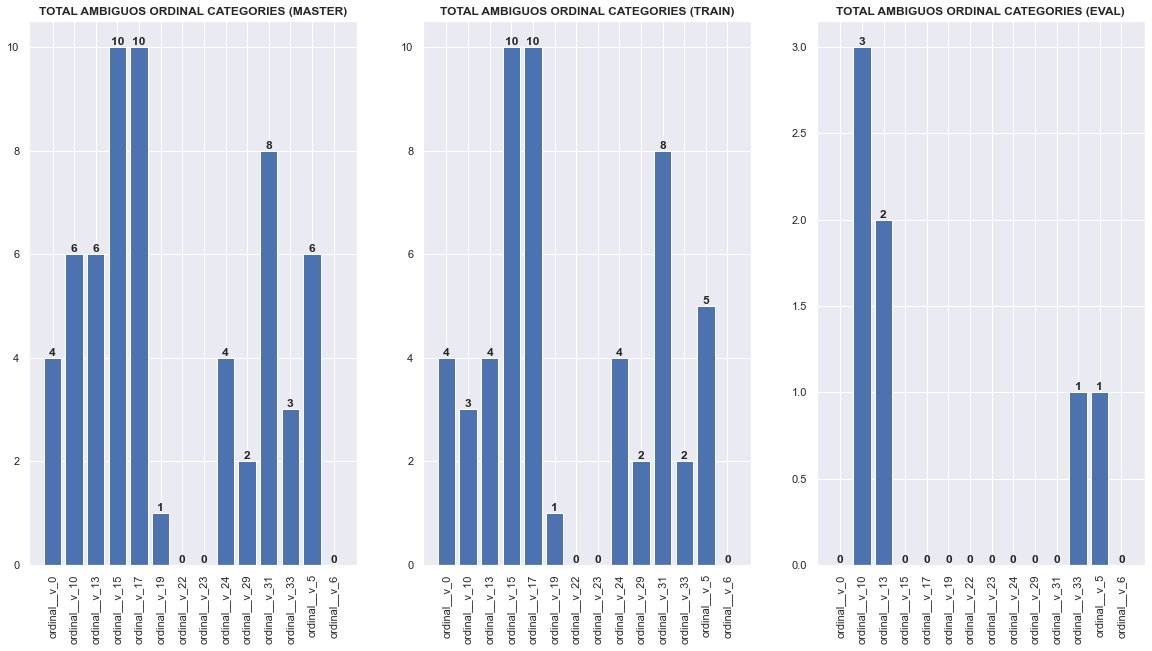

In [43]:
data_to_plot = [
    total_ambiguos_labels_master,
    total_ambiguos_labels_train,
    total_ambiguos_labels_eval,
]
data_titles = [
    "Total Ambiguos Ordinal Categories (Master)",
    "Total Ambiguos Ordinal Categories (Train)",
    "Total Ambiguos Ordinal Categories (Eval)",
]
fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(20, 10))

for idx in range(3):
    # ax_ = ax[idx]
    data = data_to_plot[idx]
    disp = ax[0, idx].bar(data.keys(), height=data.values())
    disp1 = ax[0, idx].set_xticklabels(data.keys(), rotation=90)
    disp = ax[0, idx].bar_label(container=disp, fontweight="bold")
    disp2 = ax[0, idx].set_title(data_titles[idx].upper(), fontweight="bold")

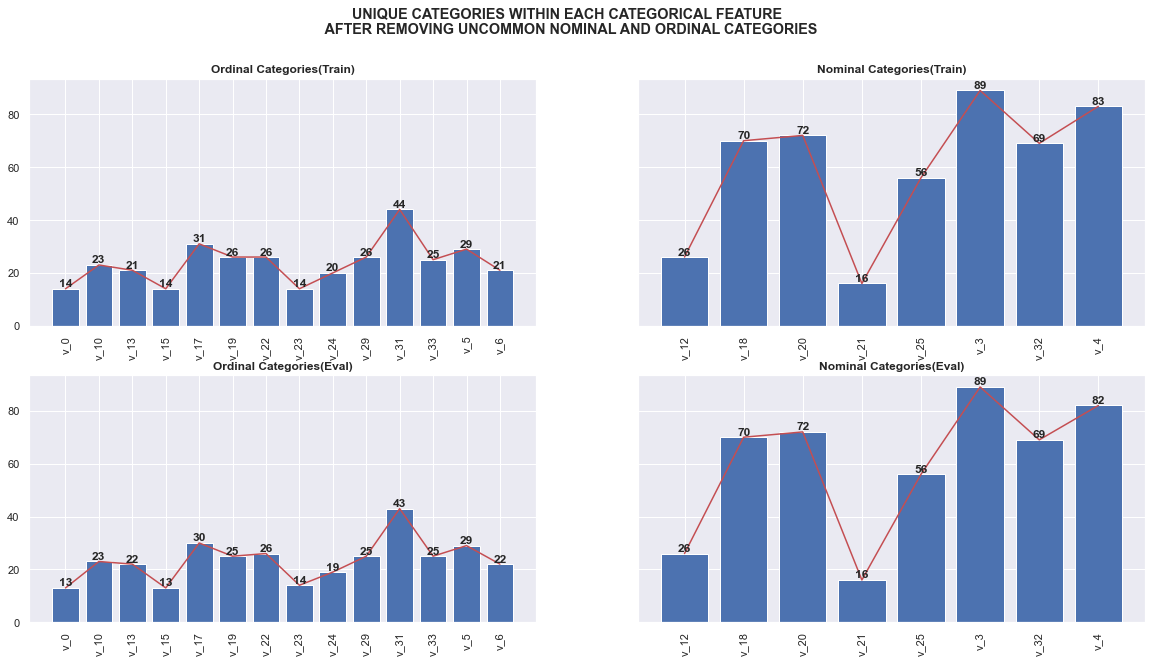

In [44]:
"""
Unique Categories within each categorical feature.
"""
fig, ax = plt.subplots(2, 2, figsize=(20, 10), squeeze=False, sharey=True)
data_to_plot = [
    ordinal_data_t,
    nominal_data_t,
    ordinal_data_eval_t,
    nominal_data_eval_t,
]
fig.suptitle(
    "Unique Categories within each categorical feature \n After removing uncommon nominal and ordinal categories".upper(),
    fontweight="bold",
)
data_titles = [
    "Ordinal Categories(Train)",
    "Nominal Categories(Train)",
    "Ordinal Categories(Eval)",
    "Nominal Categories(Eval)",
]
idx = 0
for i in range(2):
    for j in range(2):
        ax_ = ax[i, j]
        data = data_to_plot[idx]

        values = data.nunique().values
        Xlabels = [x.split("__")[1] for x in data.nunique().index]
        disp = ax_.bar(x=Xlabels, height=values)
        disp1 = ax_.set_title(data_titles[idx], fontweight="bold")
        disp2 = ax_.set_xticklabels(Xlabels, rotation=90)
        ax_.bar_label(container=disp, fontweight="bold")
        ax_.plot(values, "-r")
        idx += 1

In [45]:
categorical_columns = [ordinal, nominal]
# for catg_col in categorical_columns:
@run_if_refresh
def update_categorical_data():
    raw_data.loc[:, ordinal] = ordinal_data_t
    raw_data.loc[:, nominal] = nominal_data_t
    raw_data_eval.loc[:, ordinal] = ordinal_data_eval_t
    raw_data_eval.loc[:, nominal] = nominal_data_eval_t
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


update_categorical_data()

Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


#### Load cleaned Categorical Data

In [46]:
raw_data, ratios_data_eval = reload_raw_data()

#### Sort Columns by Alphabetical Order to group similar Data Types

In [47]:
@run_if_refresh
def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


sort_columns_by_name()

raw_data, ratios_data_eval = reload_raw_data()

Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


#### Ordinal Encoding all Nominal Categories to Reduce <br> Categorical distance and making them Uniform

In [48]:
@run_if_refresh
def ordinally_encode_nominal_data():
    ordinal_enc = OrdinalEncoder()
    nominal_enc_data = ordinal_enc.fit_transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    write_raw_data(raw_data, raw_data_eval)


ordinally_encode_nominal_data()
raw_data, ratios_data_eval = reload_raw_data()

Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


### Categorical Correlation and Feature Engineering

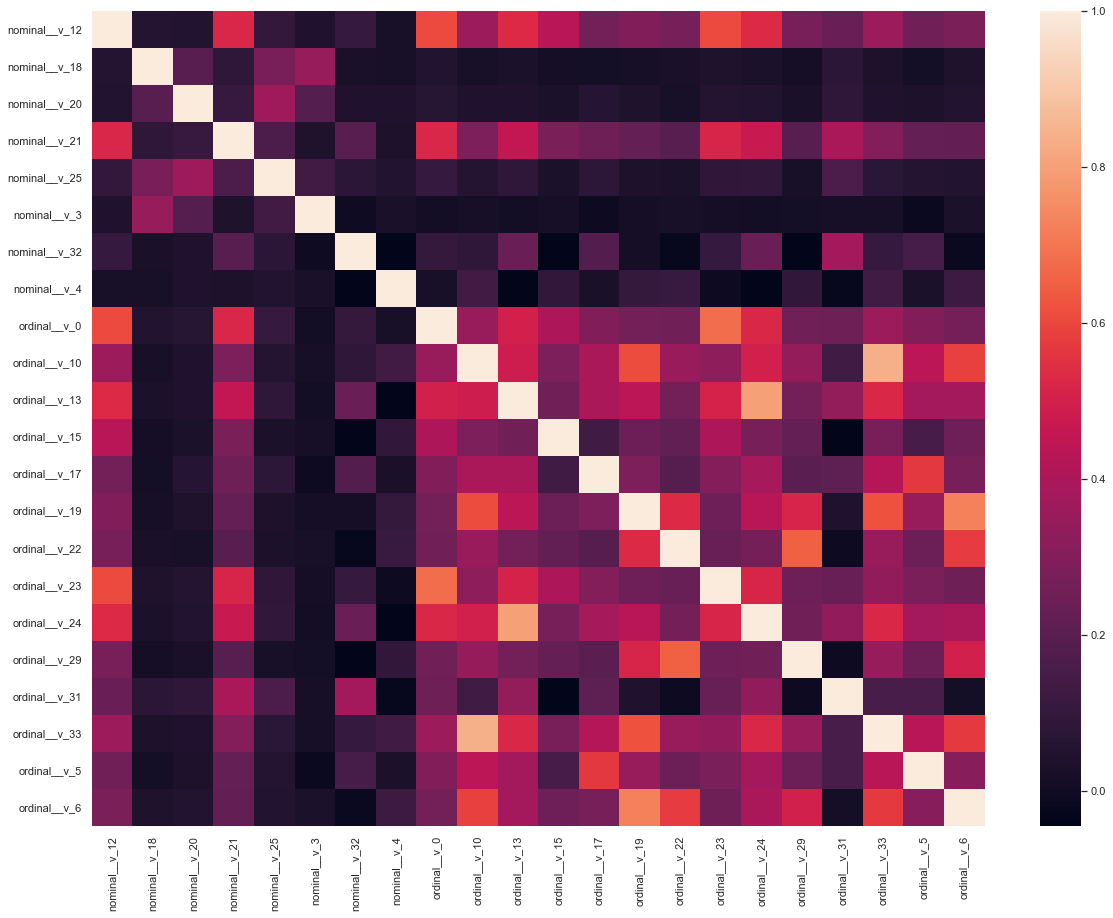

In [49]:
categorical_correlation = raw_data.loc[:,nominal+ordinal].corr(method='kendall')
plt.figure(figsize=(20,15))
disp = sns.heatmap(categorical_correlation, robust=True, )

```text
From the HeatMap it is evident that ordinal data and nominal data has interactions. They also correlate well above the threshold. Hence Examining Features which correlate with features and the effect of removing them is needed to Be explored
```

In [50]:
# clf = HistGradientBoostingClassifier()
correlated_features = set()

for i in range(len(categorical_correlation.columns)):
    for j in range(i):
        if abs(categorical_correlation.iloc[i, j]) > 0.8:
            colname = categorical_correlation.columns[i]
            correlated_features.add(colname)
            
correlated_features

{'ordinal__v_33'}

In [80]:
categorical_mask = [True]*21
X = raw_data.loc[:,nominal+ordinal]
X = X.drop(list(correlated_features),axis=1).astype('category')
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)
clf_histgbc = HistGradientBoostingClassifier(categorical_features=categorical_mask)
clf_cnb = CategoricalNB(min_categories=89,fit_prior=False)
clf_rfc = RandomForestClassifier(random_state=34,class_weight='balanced_subsample')
clf_lgc = LogisticRegressionCV(scoring='f1_macro',n_jobs=-1,class_weight='balanced',random_state=34)
tmp = make_pipeline(PolynomialWrapper(LeaveOneOutEncoder()), clf_lgc)
with parallel_backend('threading'):
    model = tmp
    y_pred = model.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test,y_pred,labels=[0,1,2]))
    scores = cross_validate(model, X, y,scoring='f1_macro',n_jobs=-1,return_train_score=True,return_estimator=True, error_score=0,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=3))
    mean_f1_score_test = scores['test_score'].mean()
    print(f'Mean F1-Score Test : {mean_f1_score_test}')
    mean_f1_score_train = scores['train_score'].mean()
    print(f'Mean F1-Score Train : {mean_f1_score_train}')
    

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       373
           1       0.77      0.76      0.77       559
           2       0.34      0.51      0.41       207

    accuracy                           0.66      1139
   macro avg       0.63      0.62      0.62      1139
weighted avg       0.70      0.66      0.67      1139

Mean F1-Score Test : 0.6226172940132654
Mean F1-Score Train : 0.6741385747417105


In [52]:
X.astype('category').describe()

,nominal__v_12,nominal__v_18,nominal__v_20,nominal__v_21,nominal__v_25,nominal__v_3,nominal__v_32,nominal__v_4,ordinal__v_0,ordinal__v_10,ordinal__v_13,ordinal__v_15,ordinal__v_17,ordinal__v_19,ordinal__v_22,ordinal__v_23,ordinal__v_24,ordinal__v_29,ordinal__v_31,ordinal__v_5,ordinal__v_6
count,3796.0,3796.0,3796.0,3796.0,3796.0,3796.0,3796.0,3796.0,3796,3796,3796,3796,3796,3796,3796,3796,3796,3796,3796,3796,3796
unique,26.0,70.0,72.0,16.0,56.0,89.0,69.0,83.0,14,23,21,14,31,26,26,14,20,26,44,29,21
top,1.0,42.0,49.0,1.0,1.0,55.0,1.0,47.0,12,25,14,10,49,24,25,3,15,18,26,39,14
freq,3076.0,1102.0,855.0,2801.0,746.0,741.0,1222.0,537.0,2963,1358,2721,2143,606,868,732,2947,2759,761,750,603,724


In [70]:
raw_data.loc[:,ordinal+nominal].corrwith(raw_data.target, method='kendall')

ordinal__v_0    -0.016195
ordinal__v_10    0.046096
ordinal__v_13   -0.005356
ordinal__v_15    0.019995
ordinal__v_17    0.086893
ordinal__v_19    0.201375
ordinal__v_22    0.241465
ordinal__v_23   -0.024082
ordinal__v_24   -0.023308
ordinal__v_29    0.191632
ordinal__v_31   -0.161296
ordinal__v_33    0.043738
ordinal__v_5     0.123660
ordinal__v_6     0.244456
nominal__v_12    0.003488
nominal__v_18    0.008782
nominal__v_20   -0.017369
nominal__v_21   -0.058796
nominal__v_25   -0.044221
nominal__v_3     0.006688
nominal__v_32   -0.095184
nominal__v_4    -0.015793
dtype: float64

###    Load Data Prepared Data

In [54]:
import pandas as pd


class DFCollection:
    """
    Contains all the data used.
    Upon Init all data gets loaded.
    Save method is also provided.
    """

    def __init__(self):
        self.c_sel = ColumnSelectors()

        self.file_path = "/kaggle/working/"
        if KAGGLE_ENV == 0:
            self.file_path = "../data" + self.file_path
        self.data = pd.read_parquet(self.file_path + "train.parquet")
        self.prediction_data = pd.read_parquet(self.file_path + "test.parquet")
        self.data_logits = pd.read_parquet(self.file_path + "data_with_ridit.hdfs")
        self.final_data = pd.read_parquet(self.file_path + "final_data.parquet")
        self.final_pred_data = pd.read_parquet(
            self.file_path + "final_pred_data.parquet"
        )

        self.core_frames = [
            self.data,
            self.prediction_data,
            self.data_logits,
            self.final_data,
        ]
        save_paths = [
            "train.parquet",
            "test.parquet",
            "data_with_ridit.hdfs",
            "final_data.parquet",
            "final_pred_data.parquet",
        ]
        self.save_paths = [self.file_path + x for x in save_paths]
        self.core_names = [x.split(".")[0] for x in self.save_paths]
        self.final_data.rename(columns={"label": "target"}, inplace=True)
        self.data.rename(columns={"label": "target"}, inplace=True)
        self.nominal_categories = {}
        for nc in self.c_sel.nominal_cols:
            ncs = self.master.loc[:, nc].unique()
            self.nominal_categories[nc] = ncs

        self.ordinal_categories = {}
        for nc in self.c_sel.ordinal_cols:
            ncs = self.master.loc[:, nc].unique()
            self.ordinal_categories[nc] = ncs

    @staticmethod
    def __save__(df: pd.DataFrame, loc: str):
        try:
            df.to_parquet(loc)
        except:
            return "Save Failed"
        return "Saved Successfully"

    def save_all(self):
        """
        Before Saving all objects ask question for each of them.
        And for each question if the answer is yes proceed to save otherwise continue.
        """
        exit_msg = "Exiting!"
        try:
            for df_name, df, df_loc in zip(
                self.core_names, self.core_frames, self.save_paths
            ):
                base_question = f"Do you want to save {df_name}?(Yes/No/Exit)"
                skip_msg = f"Skipping {df_name}"
                while True:
                    answer = input(base_question)
                    if answer == "Yes":
                        msg = self.__save__(df, df_loc)
                        print(df_name + msg)
                        break
                    elif answer in ["No", "n"]:
                        print(skip_msg)
                        break
                    elif answer in ["Exit", "e"]:
                        print(exit_msg)
                        return
                    else:
                        print("Not Valid Input")
                        continue
        except KeyboardInterrupt:
            print(exit_msg)
            return

    def categorise_data(self, df: pd.DataFrame = None):

        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.c_sel.ordinal_cols]
            nominal_data = df.loc[:, self.c_sel.nominal_cols]
            binary_data = df.loc[:, self.c_sel.binary_cols]
            ratio_data = df.loc[:, self.c_sel.ratio_cols]
        else:
            df = self.final_data
            ordinal_data = df.loc[:, self.c_sel.ordinal_cols]
            nominal_data = df.loc[:, self.c_sel.nominal_cols]
            binary_data = df.loc[:, self.c_sel.binary_cols]
            ratio_data = df.loc[:, self.c_sel.ratio_cols]
        return ordinal_data, nominal_data, binary_data, ratio_data


# if __name__ == "__main__":
#     db = DFCollection()

## Saved Standalone Models

### Categorical HistGradientBoostingClassifier

In [68]:
correlated_features = set()
categorical_correlation = raw_data.loc[:,nominal+ordinal].corr(method='kendall')
for i in range(len(categorical_correlation.columns)):
    for j in range(i):
        if abs(categorical_correlation.iloc[i, j]) > 0.8:
            colname = categorical_correlation.columns[i]
            correlated_features.add(colname)
# correlated_features = list(correlated_features)
used_columns =list(set(ordinal+nominal)-correlated_features) 
column_selection_pattern = '|'.join(used_columns)
helpers = { 
    "column_selector": make_column_selector(pattern=column_selection_pattern),
    "categorical_mask" : [True]*len(used_columns),
}
ct = ColumnTransformer(
    transformers=[
        ('select_used_columns','passthrough',helpers['column_selector'])
    ],
    n_jobs=-1,
    sparse_threshold=0
)
clf_hist_gbc = OneVsRestClassifier(
    estimator=HistGradientBoostingClassifier(random_state=42,max_bins=102,learning_rate=0.2,l2_regularization=0.9,scoring='f1_macro',categorical_features=helpers['categorical_mask']),
    n_jobs=-1
)
HistGBC_pipeline=Pipeline(steps=[
    ('columntransformer',ct),
    ('onevsrestclassifier',OneVsRestClassifier(estimator=clf_hist_gbc))
],
                          memory=joblib.Memory())
@run_if_refresh
def test_model(model=HistGBC_pipeline):
    """
    Test: HistGBC_pipeline
    """
    X = raw_data.loc[:,nominal+ordinal]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.1)

    with parallel_backend('loky'):
        # model = HistGBC_pipeline
        y_pred = model.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test,y_pred,labels=[0,1,2]))
        scores = cross_validate(model, X, y,scoring='f1_macro',n_jobs=-1,return_train_score=True,return_estimator=True, error_score=0,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=3))
        mean_f1_score_test = scores['test_score'].mean()
        print(f'Mean F1-Score Test : {mean_f1_score_test}')
        mean_f1_score_train = scores['train_score'].mean()
        print(f'Mean F1-Score Train : {mean_f1_score_train}')

        
test_model()
HistGBC_pipeline


Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


Pipeline(memory=Memory(location=None),
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('select_used_columns',
                                                  'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffaf07cfc70>)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=OneVsRestClassifier(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True,
                                                                                                                                  True],
                                                                                                            l2_regularization=0.9,
                                                                                                            learning_rate=0.2,
                                                                                                            max_bins=102,
                                                                                                            random_state=42,
                                                                                                            scoring='f1_macro'),
                                                 

### Categorical RandomForestClassifier

In [67]:
correlated_features = set()
categorical_correlation = raw_data.loc[:,nominal+ordinal].corr(method='kendall')
for i in range(len(categorical_correlation.columns)):
    for j in range(i):
        if abs(categorical_correlation.iloc[i, j]) > 0.8:
            colname = categorical_correlation.columns[i]
            correlated_features.add(colname)

used_columns =list(set(ordinal+nominal)-correlated_features) 
column_selection_pattern = '|'.join(used_columns)

helpers = { 
    "column_selector": make_column_selector(pattern=column_selection_pattern),
}
ct = ColumnTransformer(
    transformers=[
        ('select_used_columns','passthrough',helpers['column_selector'])
    ],
    n_jobs=-1,
    sparse_threshold=0
)
clf_rfc = OneVsRestClassifier(
    estimator=RandomForestClassifier(
        random_state=34,
        # n_jobs=-1,
        class_weight='balanced_subsample',
        # max_features='log',
    ),
    n_jobs=-1
)
RFC_pipeline=Pipeline(steps=[
    ('columntransformer',ct),
    ('onevsrestclassifier',OneVsRestClassifier(estimator=clf_rfc))
],
                          memory=joblib.Memory())
@run_if_refresh
def test_model(model=RFC_pipeline):
    """
    Test: Model Pipeline
    """
    X = raw_data.loc[:,nominal+ordinal]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)

    with parallel_backend('loky'):
        # model = HistGBC_pipeline
        y_pred = model.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test,y_pred,labels=[0,1,2]))
        scores = cross_validate(model, X, y,scoring='f1_macro',n_jobs=-1,return_train_score=True,return_estimator=True, error_score=0,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=3))
        mean_f1_score_test = scores['test_score'].mean()
        print(f'Mean F1-Score Test : {mean_f1_score_test}')
        mean_f1_score_train = scores['train_score'].mean()
        print(f'Mean F1-Score Train : {mean_f1_score_train}')

        
test_model()
RFC_pipeline


Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


Pipeline(memory=Memory(location=None),
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('select_used_columns',
                                                  'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffb18643940>)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                                                    random_state=34),
                                                                   n_jobs=-1)))])

### Categorical LogisticRegressionCV

In [117]:
correlated_features = set()
categorical_correlation = raw_data.loc[:,nominal+ordinal].corr(method='kendall')
for i in range(len(categorical_correlation.columns)):
    for j in range(i):
        if abs(categorical_correlation.iloc[i, j]) > 0.8:
            colname = categorical_correlation.columns[i]
            correlated_features.add(colname)

used_columns =list(set(ordinal+nominal)-correlated_features) 
column_selection_pattern = '_*|'.join(used_columns)
tmp = make_pipeline(PolynomialWrapper(LeaveOneOutEncoder()), clf_lgc)
helpers = { 
    "column_selector": make_column_selector(pattern=column_selection_pattern),
}
ct = ColumnTransformer(
    transformers=[
        ('select_used_columns','passthrough',helpers['column_selector'])
    ],
    n_jobs=-1,
    sparse_threshold=0
)
clf_lgc = LogisticRegressionCV(max_iter=10000,scoring='f1_macro',n_jobs=-1,class_weight='balanced',random_state=34)

LGC_pipeline=Pipeline(steps=[
    ('encoder', PolynomialWrapper(TargetEncoder())),
    ('columntransformer',ct),
    # ('variance_threshold', VarianceThreshold(thresho)),
    ('onevsrestclassifier',OneVsRestClassifier(estimator=clf_lgc))
    # ('onevsrestclassifier',clf_lgc)
],
                          memory=joblib.Memory())
# @run_if_refresh
def test_model(model=LGC_pipeline):
    """
    Test: Model Pipeline
    """
    X = raw_data.loc[:,nominal+ordinal].astype('category')
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)

    with parallel_backend('loky'):
        # model = HistGBC_pipeline
        y_pred = model.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test,y_pred,labels=[0,1,2]))
        scores = cross_validate(model, X, y,scoring='f1_macro',n_jobs=-1,return_train_score=True,return_estimator=True, error_score=0,cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=3))
        mean_f1_score_test = scores['test_score'].mean()
        print(f'Mean F1-Score Test : {mean_f1_score_test}')
        mean_f1_score_train = scores['train_score'].mean()
        print(f'Mean F1-Score Train : {mean_f1_score_train}')

        
test_model()
LGC_pipeline


              precision    recall  f1-score   support

           0       0.72      0.60      0.66       373
           1       0.75      0.75      0.75       559
           2       0.33      0.44      0.38       207

    accuracy                           0.64      1139
   macro avg       0.60      0.60      0.60      1139
weighted avg       0.67      0.64      0.65      1139

Mean F1-Score Test : 0.6188454507935085
Mean F1-Score Train : 0.7176472382338591


Pipeline(memory=Memory(location=None),
         steps=[('encoder', PolynomialWrapper(feature_encoder=TargetEncoder())),
                ('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('select_used_columns',
                                                  'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffac9ae42b0>)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LogisticRegressionCV(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    n_jobs=-1,
                                                                    random_state=34,
                                                                    scoring='f1_macro')))])

<AxesSubplot:>

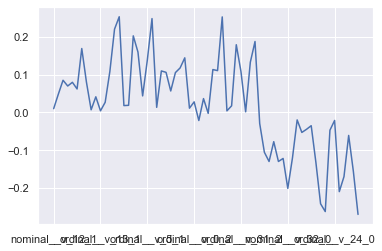

In [101]:
encoder = PolynomialWrapper(TargetEncoder())
x_t = encoder.fit_transform(raw_data.loc[:,nominal+ordinal].astype('category'), raw_data.target)
x_t.corrwith(raw_data.target,method='kendall').plot()

### Cohen Kappa Statistic of Classifier Prediction

In [119]:
models = [LGC_pipeline,RFC_pipeline]
predictions = []
for model in models:
    y_pred = model.fit(X_train, y_train).predict(X_test)
    predictions.append(y_pred)

cohen_kappa_score(*predictions)

0.5802276442108748